# Preparing working environnment

In [1]:
import pandas as pd
import numpy as np
import PIL

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
# Import dataset
data = pd.read_csv('Flipkart/flipkart_com-ecommerce_sample_1050.csv')

In [3]:
# Dropping unnecessary columns
data = data[['uniq_id', 'product_category_tree', 'image']]

In [4]:
# Retrieving categories
df_categ = data['product_category_tree'].str.split(pat = '>>', expand = True)
df_categ[0] = df_categ[0].apply(lambda x: str(x)[2:] if str(x)[:2] == '["' else x)
for c in np.arange(0,7,1):
    df_categ[c] = df_categ[c].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '"]' else x)
    
data = data.join(df_categ.iloc[:,:2])
data.rename(columns = {0 : 'category', 1 : 'subcategory'}, inplace = True)
data.drop(columns = 'product_category_tree', inplace = True)

# Testing processing on a single image

In [5]:
data['image'][0]

'55b85ea15a1536d46b7190ad6fff8ce7.jpg'

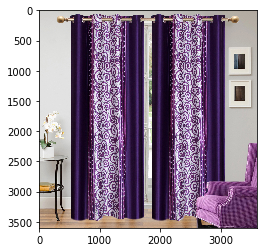

In [6]:
# Loading an image
image_path = 'Flipkart/Images/'
test_img = PIL.Image.open(image_path + data['image'][0])
plt.imshow(test_img, cmap = 'binary_r')
plt.show()

In [7]:
test_img.mode

'RGB'

In [8]:
test_img.size

(3600, 3600)

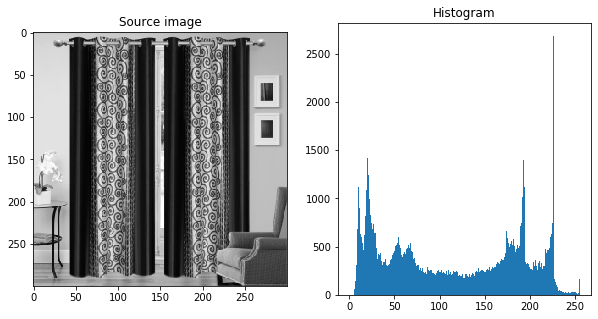

In [9]:
# Converting to black and white, rescaling & getting histogram
test_img2 = test_img.convert(mode = 'L')
factor = int(min(test_img.size)/300)
test_img2 = test_img2.reduce(factor)

plt.figure(figsize = (10,5))
plt.subplot(121)
plt.imshow(test_img2, cmap = 'binary_r')
plt.title('Source image')

plt.subplot(122)
plt.hist(np.array(test_img2).flatten(), bins = range(256))
plt.title('Histogram')
plt.show()

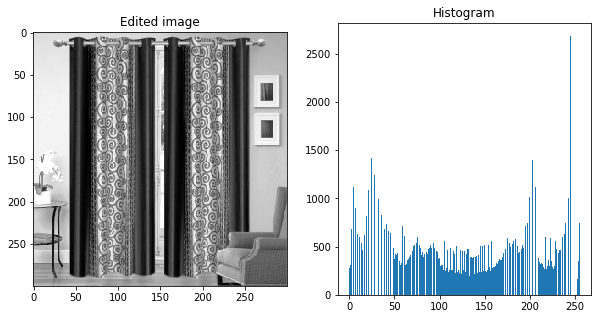

In [10]:
# Enhancing contrast and brightness
from PIL import ImageOps

test_img_ac = ImageOps.autocontrast(test_img2)
test_img_eq = ImageOps.equalize(test_img_ac)

plt.figure(figsize = (10,5))
plt.subplot(121)
plt.imshow(test_img_eq, cmap = 'binary_r')
plt.title('Edited image')

plt.subplot(122)
plt.hist(np.array(test_img_eq).flatten(), bins = range(256))
plt.title('Histogram')
plt.show()

In [11]:
save_path = 'Flipkart/Edited_Images/'
test_img_eq.save(save_path + data['image'][0])

# Editing all images

In [12]:
# Function for editing and storing all images to a new folder
def edit_images(source_path, dest_path, min_size, binary):
    
    for i in range(len(data['image'])):
        # Getting an image
        im_name = data['image'][i]
        img = PIL.Image.open(source_path + im_name)
        
        # Conversion to black & white
        img = img.convert(mode = 'L') if binary else img
        
        # Size reduction        
        factor = int(min(img.size)/min_size)
        factor = 1 if factor == 0 else factor
        img = img.reduce(factor)
        
        # Image enhancement
        img = ImageOps.autocontrast(img)
        img = ImageOps.equalize(img)
        
        # Storing new image
        img.save(dest_path + im_name)

In [13]:
# Storing black & white images with min size = 300
edit_images('Flipkart/Images/', 'Flipkart/Edited_Images_NB300/', 300, True)

C:\Users\alexa_000\Anaconda3\lib\site-packages\PIL\Image.py:2766: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


# Testing SIFT algorithm

## Features and descriptors

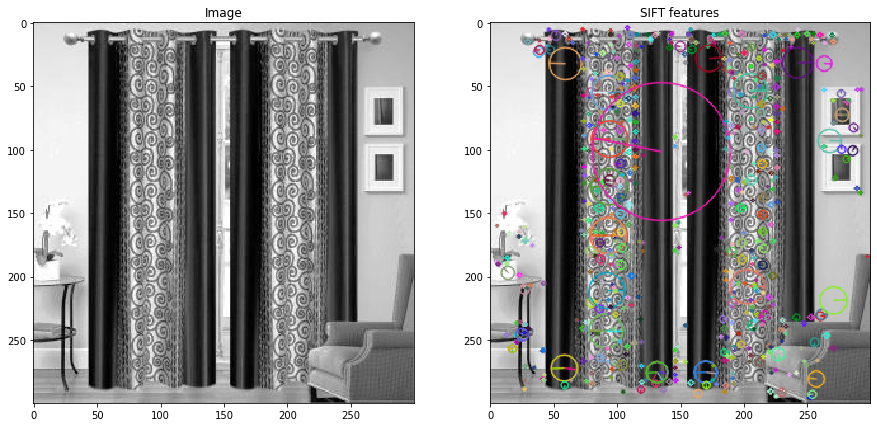

In [14]:
import cv2

# Load an image
save_path = 'Flipkart/Edited_Images_NB300/'
test_img = cv2.imread(save_path + data['image'][0])

# Create a SIFT object
sift = cv2.xfeatures2d.SIFT_create()
#gray= cv2.cvtColor(test_img,cv2.COLOR_BGR2GRAY)

# Detect and drqw keypoints
kp = sift.detect(test_img, None)
test_kp = cv2.drawKeypoints(test_img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize = (15,30))
plt.subplot(121)
plt.imshow(test_img)
plt.title('Image')

plt.subplot(122)
plt.imshow(test_kp, cmap = 'binary_r')
plt.title('SIFT features')
plt.show()

In [15]:
# Keypoints and descriptors
kp, des = sift.detectAndCompute(test_img, None)
des.shape

(643, 128)

In [16]:
# Normalization and clipping
def norm_clip(descriptor):
    des_clip = np.clip(descriptor/np.linalg.norm(descriptor),0, 0.2)
    des_norm = des_clip/np.linalg.norm(des_clip)
    return des_norm

# Normalize all descriptors of detected feature
des_n = np.apply_along_axis(norm_clip, 1, des)

## Finding visual words

tester un clustering (sans RDim) sur les descripteurs de cette image pour repérer les descripteurs identiques (motifs du rideau). clustering en kmeans avec nb de cluster entre 100 et 1000 avec un pas de 50, score d'inertie + méthode du coude

Training with 100 clusters
Training with 150 clusters
Training with 200 clusters
Training with 250 clusters
Training with 300 clusters
Training with 350 clusters
Training with 400 clusters
Training with 450 clusters
Training with 500 clusters


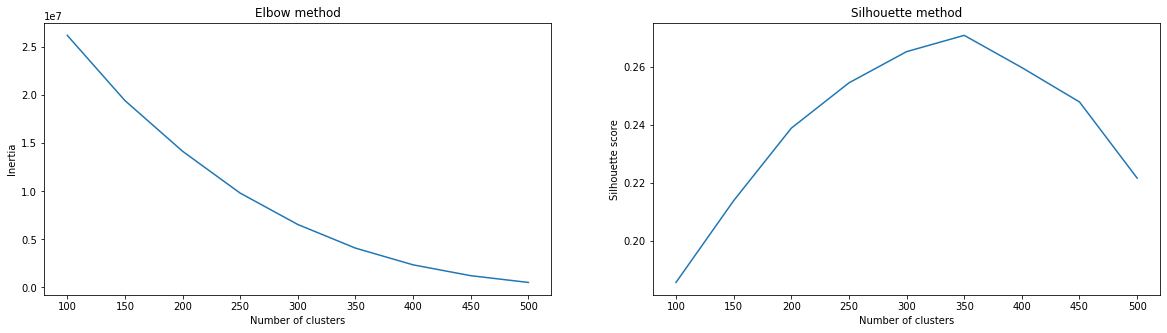

In [17]:
# Optimal number of clusters
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

l_inertia = []
l_sil = []
clt_range = range(100, 550, 50)

kp_sift, des_sift = sift.detectAndCompute(test_img, None)

# Training Kmeans algorithm
for nb_clt in clt_range:
    print("Training with {} clusters".format(nb_clt))
    km = KMeans(n_clusters = nb_clt)
    km.fit(des_sift)
    l_inertia.append(km.inertia_)
    l_sil.append(silhouette_score(des_sift, km.labels_))
    
# Visualization of inertia
plt.figure(figsize = (20,5))
plt.subplot(121)
plt.plot(clt_range, l_inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow method')

plt.subplot(122)
plt.plot(clt_range, l_sil)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette method')
plt.show()

combien de points dans les clusters ==> threshold

In [115]:
# Training with 350 clusters and creating visual words
km350 = KMeans(n_clusters = 350)
km350.fit(des)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=350, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

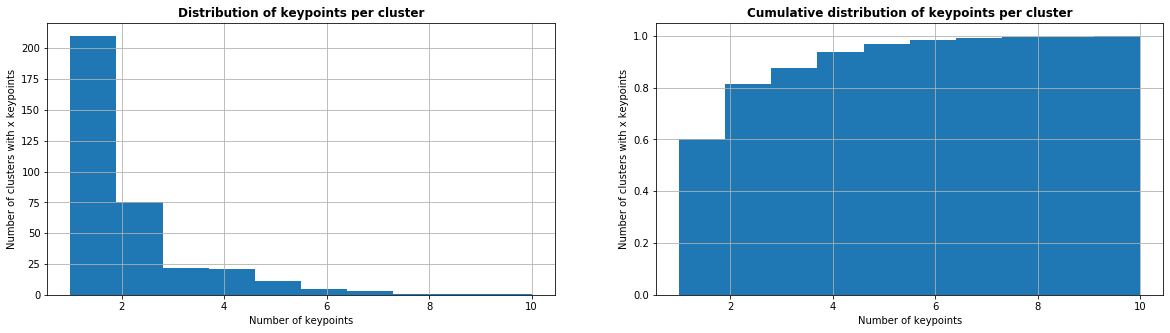

In [116]:
# Number of keypoints per cluster
df_temp = pd.DataFrame(km350.labels_)
df_temp['count'] = 1
df_gr_ = df_temp.groupby(by = 0).sum()

plt.figure(figsize = (20,5))
plt.subplot(121)
plt.hist(df_gr_['count'])
plt.xlabel('Number of keypoints')
plt.ylabel('Number of clusters with x keypoints')
plt.title('Distribution of keypoints per cluster', fontweight = 'bold')
plt.grid(True)

plt.subplot(122)
plt.hist(df_gr_['count'], density = True, cumulative = True)
plt.xlabel('Number of keypoints')
plt.ylabel('Number of clusters with x keypoints')
plt.title('Cumulative distribution of keypoints per cluster', fontweight = 'bold')
plt.grid(True)

plt.show()

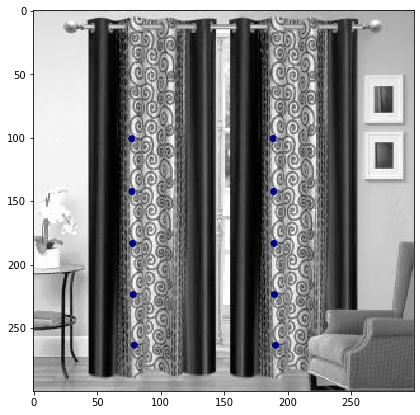

In [117]:
# Clusters with at least 9 keypoints
l_main_clusters = df_gr_[df_gr_['count']>9].index.tolist()

x_ = [x.pt[0] for x in kp if km350.labels_[kp.index(x)] in l_main_clusters]
y_ = [x.pt[1] for x in kp if km350.labels_[kp.index(x)] in l_main_clusters]
c_ = [x for x in km350.labels_ if x in l_main_clusters]

plt.figure(figsize = (7,7))
plt.imshow(test_img)
plt.scatter(x_, y_, c = c_, cmap = 'jet')

plt.show()

## Generalization to more images

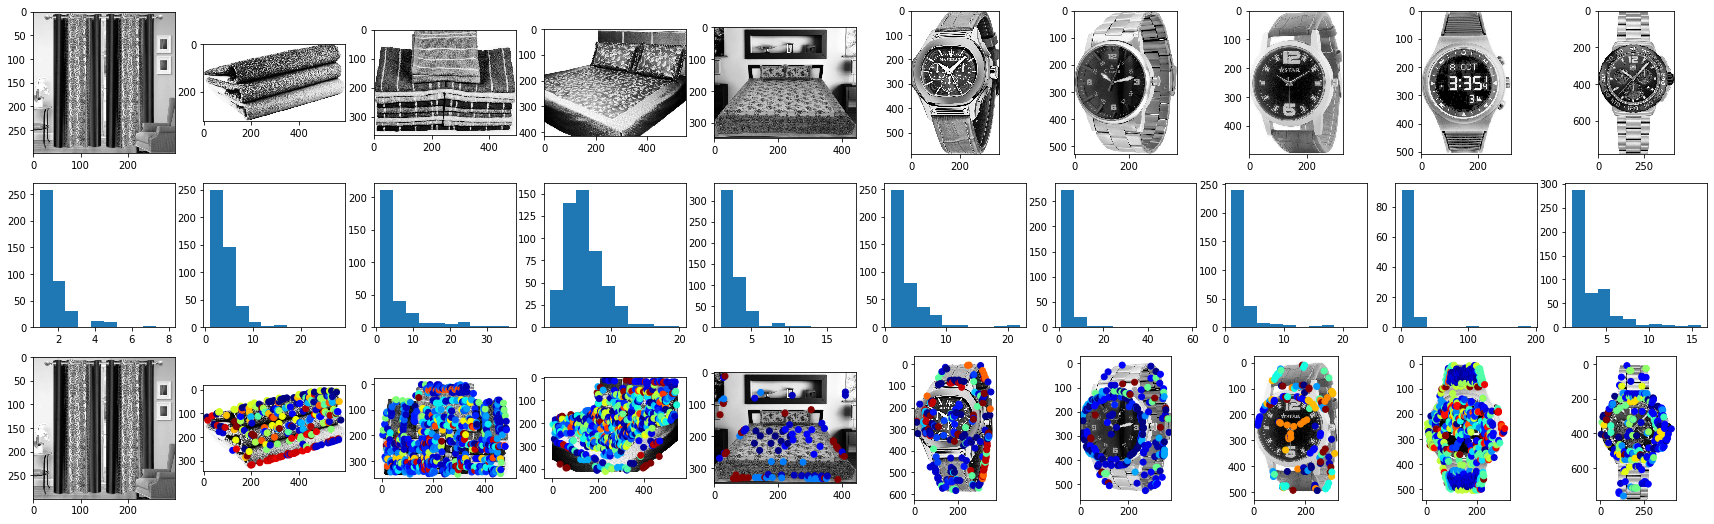

In [74]:
# Finding clusters with at least 10 key points on 10 different images
plt.figure(figsize = (30,9))

for i in range(10):
    # Select and show image
    img = cv2.imread(save_path + data['image'][i])
    plt.subplot(3,10, 1+i)
    plt.imshow(img)
    
    # Perform SIFT and retrieve keypoints
    kp, des = sift.detectAndCompute(img, None)
    
    # Find optimal number of clusters and perform clustering
    l_sil = []
    clt_range = range(100, 550, 50)
    
    for k in clt_range:
        km = KMeans(n_clusters = k)
        km.fit(des)
        l_sil.append(silhouette_score(des, km.labels_))
                     
    k_opt = np.arange(100, 550, 50)[l_sil.index(max(l_sil))]
    km_opt = KMeans(n_clusters = k_opt)
    km_opt.fit(des)
    
    # Number of keypoints per cluster
    df_temp = pd.DataFrame(km_opt.labels_)
    df_temp['count'] = 1
    df_gr_ = df_temp.groupby(by = 0).sum()
    
    plt.subplot(3, 10, 11+i)
    plt.hist(df_gr_['count'])
    
    # Main features
    l_main_clusters = df_gr_[df_gr_['count']>9].index.tolist()
    x_ = [x.pt[0] for x in kp if km_opt.labels_[kp.index(x)] in l_main_clusters]
    y_ = [x.pt[1] for x in kp if km_opt.labels_[kp.index(x)] in l_main_clusters]
    c_ = [x for x in km_opt.labels_ if x in l_main_clusters]
    
    plt.subplot(3, 10, 21 + i)
    plt.imshow(img)
    plt.scatter(x_, y_, c = c_, cmap = 'jet')
    
plt.show()

récupérer les 20% de clusters avec le plus de keypoints ?

## Comparing 2 images

refaire le calcul des descripteurs sur des images similaires pour détecter les descripteurs communs(feature matching) : 
https://pysource.com/2018/03/23/feature-matching-brute-force-opencv-3-4-with-python-3-tutorial-26/

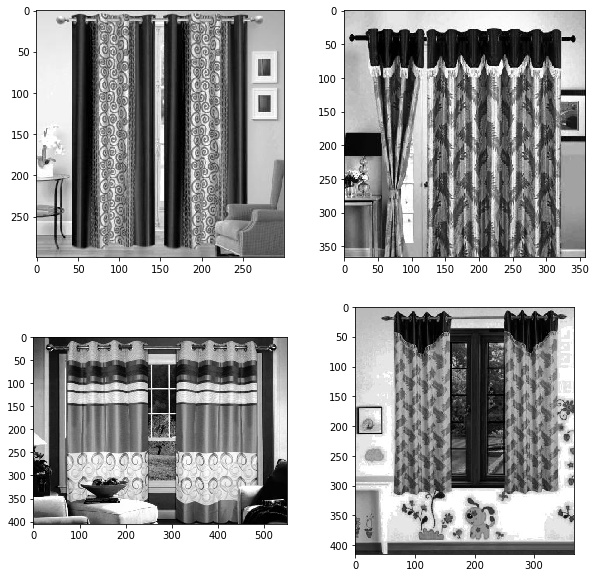

In [23]:
# Selection of a few images in same category as first image
categ = data['subcategory'][0]
im_sample = data[data['subcategory'] == categ]['image'].sample(3).values

img1 = cv2.imread(save_path + im_sample[0])
img2 = cv2.imread(save_path + im_sample[1])
img3 = cv2.imread(save_path + im_sample[2])

# Visualization
plt.figure(figsize = (10,10))
plt.subplot(2,2,1)
plt.imshow(test_img)
plt.subplot(2,2,2)
plt.imshow(img1)
plt.subplot(2,2,3)
plt.imshow(img2)
plt.subplot(2,2,4)
plt.imshow(img3)
plt.show()

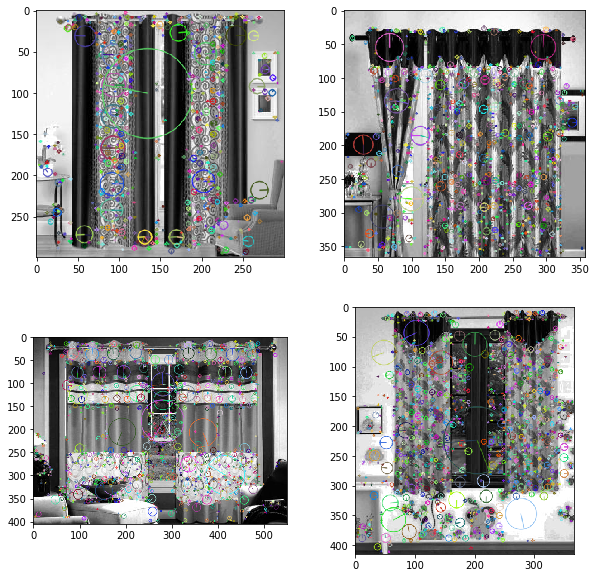

In [24]:
# Finding descriptors of each image
sift = cv2.xfeatures2d.SIFT_create()

kp0, des0 = sift.detectAndCompute(test_img, None)
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)
kp3, des3 = sift.detectAndCompute(img3, None)

imkp0 = cv2.drawKeypoints(test_img, kp0, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imkp1 = cv2.drawKeypoints(img1, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imkp2 = cv2.drawKeypoints(img2, kp2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imkp3 = cv2.drawKeypoints(img3, kp3, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Visualization
plt.figure(figsize = (10,10))
plt.subplot(2,2,1)
plt.imshow(imkp0)
plt.subplot(2,2,2)
plt.imshow(imkp1)
plt.subplot(2,2,3)
plt.imshow(imkp2)
plt.subplot(2,2,4)
plt.imshow(imkp3)
plt.show()

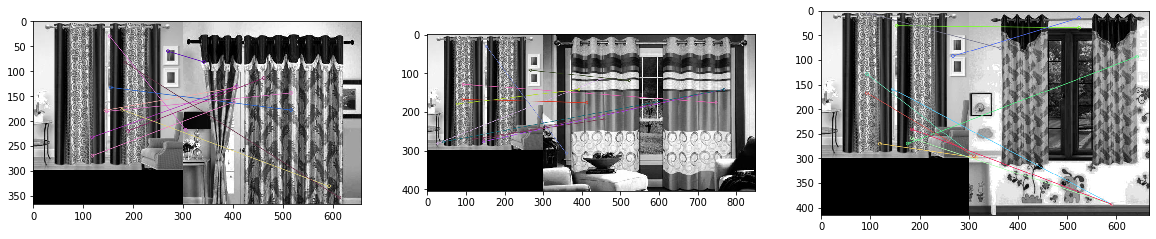

In [25]:
# Feature matching
bf = cv2.BFMatcher(cv2.NORM_L2)
matches1 = bf.match(des0, des1)
matches1 = sorted(matches1, key = lambda x: x.distance)
matching_result1 = cv2.drawMatches(test_img, kp0, img1, kp1, matches1[:10], None, flags=2)

matches2 = bf.match(des0, des2)
matches2 = sorted(matches2, key = lambda x: x.distance)
matching_result2 = cv2.drawMatches(test_img, kp0, img2, kp2, matches2[:10], None, flags=2)

matches3 = bf.match(des0, des3)
matches3 = sorted(matches3, key = lambda x: x.distance)
matching_result3 = cv2.drawMatches(test_img, kp0, img3, kp3, matches3[:10], None, flags=2)

plt.figure(figsize = (20,20))
plt.subplot(131)
plt.imshow(matching_result1)
plt.subplot(132)
plt.imshow(matching_result2)
plt.subplot(133)
plt.imshow(matching_result3)
plt.show()

In [26]:
print([int(x.distance) for x in matches1][:10])
print([int(x.distance) for x in matches2][:10])
print([int(x.distance) for x in matches3][:10])

[129, 136, 148, 149, 152, 152, 156, 156, 158, 158]
[110, 114, 116, 133, 136, 143, 143, 144, 150, 159]
[114, 115, 143, 162, 163, 164, 169, 171, 183, 184]


## Changing SIFT parameters

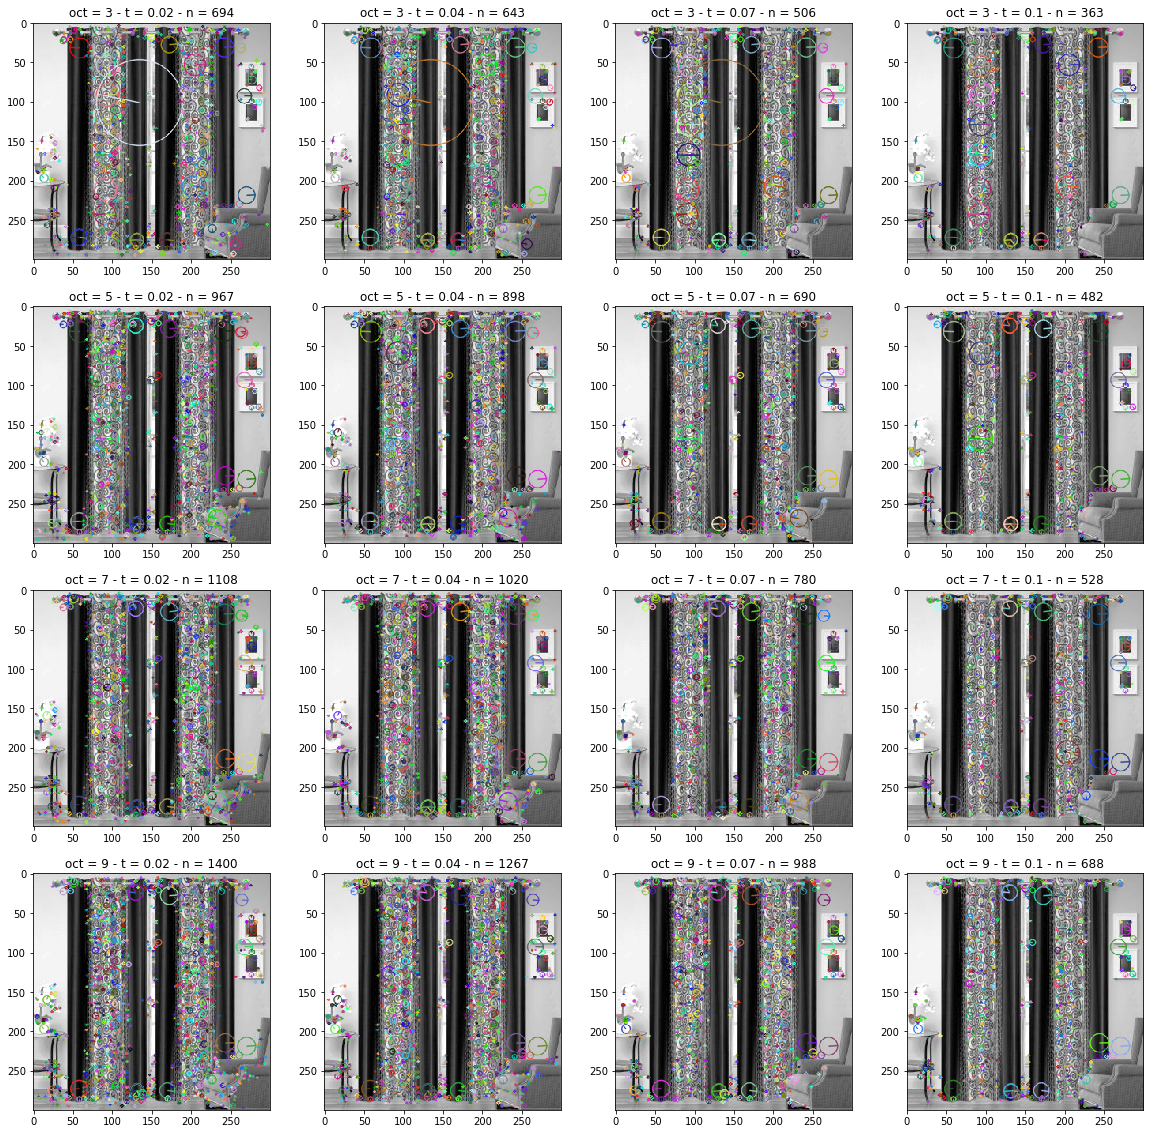

In [27]:
# Octaves and threshold

plt.figure(figsize = (20,20))
i = 0
for n_oct in [3, 5, 7, 9]:
    for thres in [0.02, 0.04, 0.07, 0.1]:
        i+= 1
        plt.subplot(4,4,i)

        # Create a SIFT object
        sift = cv2.xfeatures2d.SIFT_create(nOctaveLayers = n_oct, contrastThreshold = thres)

        # Detect and draw keypoints
        kp = sift.detect(test_img, None)
        test_kp = cv2.drawKeypoints(test_img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        n_kp = len(kp)
        
        plt.imshow(test_kp, cmap = 'binary_r')
        plt.title('oct = {} - t = {} - n = {}'.format(n_oct, thres, n_kp))

plt.show()

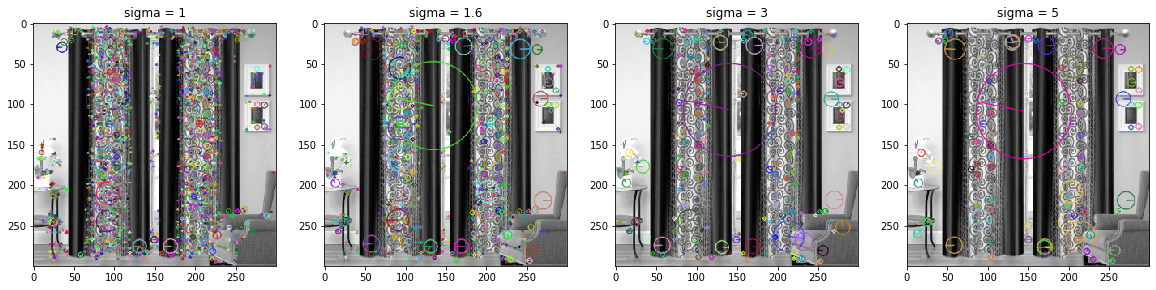

In [28]:
# sigma
plt.figure(figsize = (20,20))
i = 0
for sig in [1, 1.6, 3, 5]:
    i+= 1
    plt.subplot(1,4,i)

    # Create a SIFT object
    sift = cv2.xfeatures2d.SIFT_create(sigma = sig)

    # Detect and draw keypoints
    kp = sift.detect(test_img, None)
    test_kp = cv2.drawKeypoints(test_img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(test_kp, cmap = 'binary_r')
    plt.title('sigma = {}'.format(sig))

plt.show()

# Testing ORB

## Features and descriptors

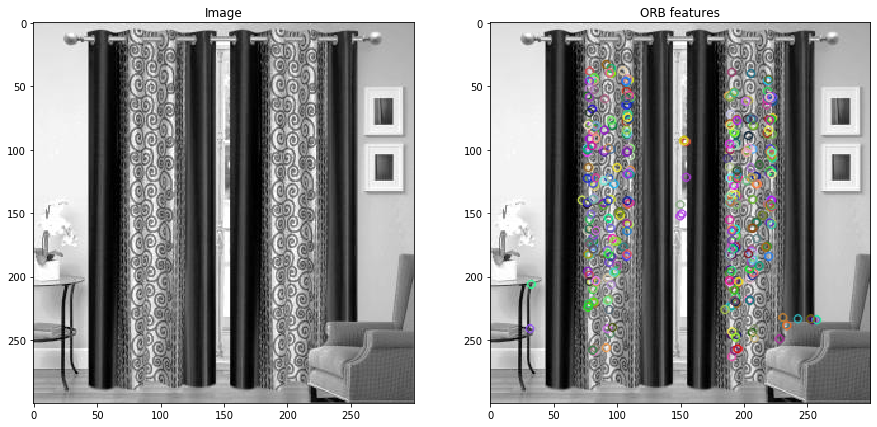

In [29]:
# Create an ORB object
orb = cv2.ORB_create()

# Detect and draw keypoints
kp_orb = orb.detect(test_img, None)
test_kp = cv2.drawKeypoints(test_img, kp_orb, None)

plt.figure(figsize = (15,30))
plt.subplot(121)
plt.imshow(test_img)
plt.title('Image')

plt.subplot(122)
plt.imshow(test_kp, cmap = 'binary_r')
plt.title('ORB features')
plt.show()

In [30]:
len(kp_orb)

458

## Finding visual words

Training with 100 clusters
Training with 150 clusters
Training with 200 clusters
Training with 250 clusters
Training with 300 clusters
Training with 350 clusters
Training with 400 clusters


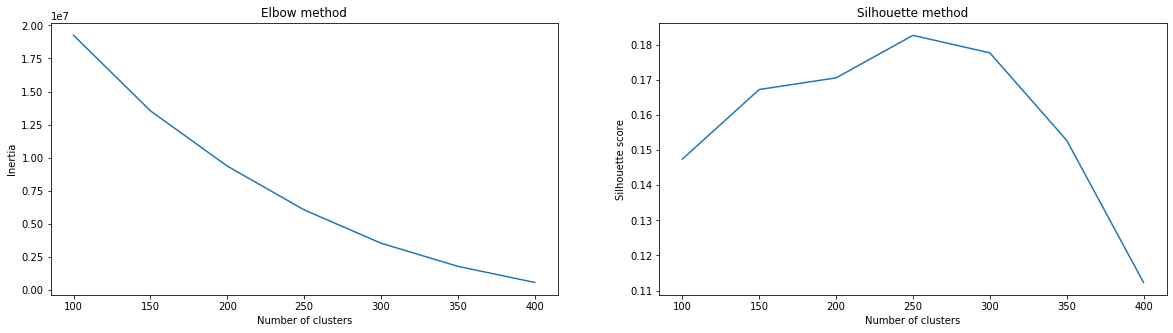

In [31]:
l_inertia = []
l_sil = []
clt_range = range(100, 450, 50)

from sklearn.metrics import silhouette_score

kp_orb, des_orb = orb.detectAndCompute(test_img, None)

# Training Kmeans algorithm
for nb_clt in clt_range:
    print("Training with {} clusters".format(nb_clt))
    km = KMeans(n_clusters = nb_clt)
    km.fit(des_orb)
    l_inertia.append(km.inertia_)
    l_sil.append(silhouette_score(des_orb, km.labels_))
    
# Visualization of inertia
plt.figure(figsize = (20,5))
plt.subplot(121)
plt.plot(clt_range, l_inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow method')

plt.subplot(122)
plt.plot(clt_range, l_sil)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette method')
plt.show()

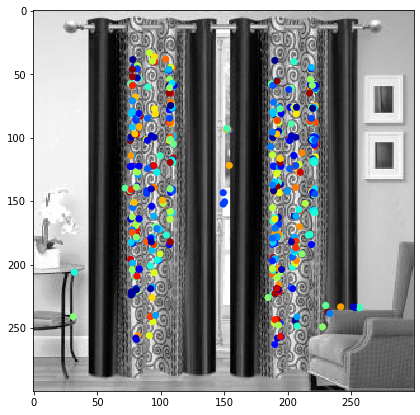

In [32]:
# Training with 250 clusters and creating visual words
km = KMeans(n_clusters = 250)
km.fit(des_orb)

plt.figure(figsize = (7,7))
plt.imshow(test_img)
x_ = [keypoint.pt[0] for keypoint in kp_orb]
y_ = [keypoint.pt[1] for keypoint in kp_orb]
plt.scatter(x_, y_, c = km.labels_, cmap = 'jet')

plt.show()

## Comparing images with ORB

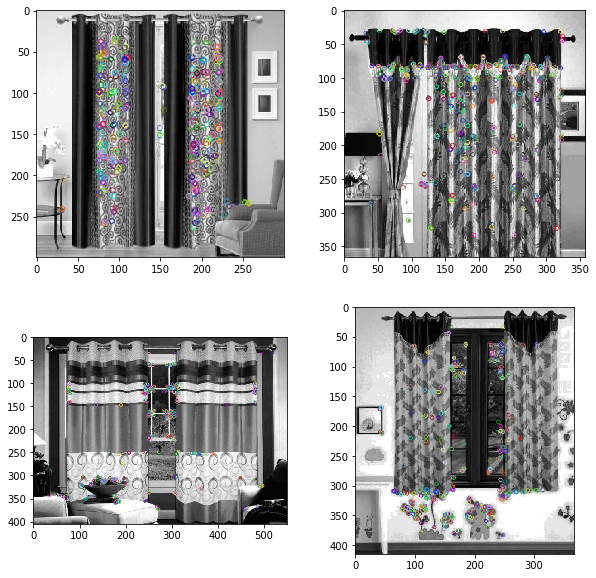

In [33]:
# Finding descriptors of each image
orb = cv2.ORB_create()

kp0, des0 = orb.detectAndCompute(test_img, None)
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)
kp3, des3 = orb.detectAndCompute(img3, None)

imkp0 = cv2.drawKeypoints(test_img, kp0, None)
imkp1 = cv2.drawKeypoints(img1, kp1, None)
imkp2 = cv2.drawKeypoints(img2, kp2, None)
imkp3 = cv2.drawKeypoints(img3, kp3, None)

# Visualization
plt.figure(figsize = (10,10))
plt.subplot(2,2,1)
plt.imshow(imkp0)
plt.subplot(2,2,2)
plt.imshow(imkp1)
plt.subplot(2,2,3)
plt.imshow(imkp2)
plt.subplot(2,2,4)
plt.imshow(imkp3)
plt.show()

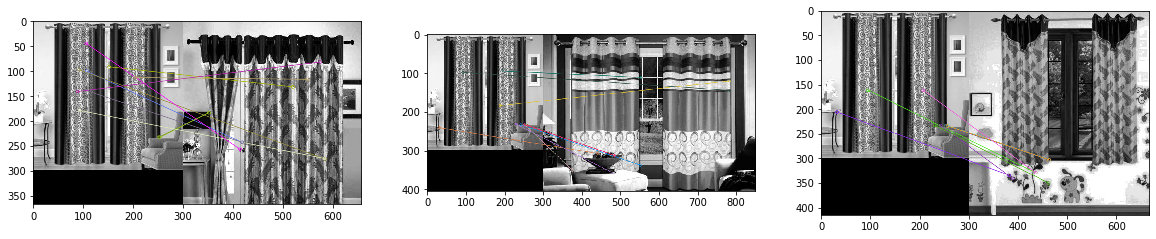

In [34]:
# Feature matching
bf = cv2.BFMatcher(cv2.NORM_HAMMING)
matches1 = bf.match(des0, des1)
matches1 = sorted(matches1, key = lambda x: x.distance)
matching_result1 = cv2.drawMatches(test_img, kp0, img1, kp1, matches1[:10], None, flags=2)

matches2 = bf.match(des0, des2)
matches2 = sorted(matches2, key = lambda x: x.distance)
matching_result2 = cv2.drawMatches(test_img, kp0, img2, kp2, matches2[:10], None, flags=2)

matches3 = bf.match(des0, des3)
matches3 = sorted(matches3, key = lambda x: x.distance)
matching_result3 = cv2.drawMatches(test_img, kp0, img3, kp3, matches3[:10], None, flags=2)

plt.figure(figsize = (20,20))
plt.subplot(131)
plt.imshow(matching_result1)
plt.subplot(132)
plt.imshow(matching_result2)
plt.subplot(133)
plt.imshow(matching_result3)
plt.show()

In [35]:
print([int(x.distance) for x in matches1][:10])
print([int(x.distance) for x in matches2][:10])
print([int(x.distance) for x in matches3][:10])

[42, 51, 52, 52, 52, 53, 54, 54, 55, 55]
[57, 57, 58, 60, 62, 63, 64, 64, 65, 65]
[34, 36, 45, 46, 52, 56, 57, 57, 57, 58]


# Finding all descriptors

## Functions

In [161]:
def find_n_clusters(des, clt_range = range(100, 550, 50)):
    """
    Searches the optimal number of clusters for given descriptors
    Returns a k-means model fitted on descriptors with best number of clusters
    """
    l_sil = []
    
    for k in clt_range:
        km = KMeans(n_clusters = k)
        km.fit(des)
        l_sil.append(silhouette_score(des, km.labels_))
                     
    k_opt = clt_range[l_sil.index(max(l_sil))]
    km_opt = KMeans(n_clusters = k_opt)
    km_opt.fit(des)
    
    return km_opt

In [189]:
def filter_clusters(kp, des, km_model, threshold = 10):
    """
    Return the centroids of cluster in km_model containing more keypoints than the threshold
    """
    # Number of keypoints per cluster
    df_temp = pd.DataFrame(km_model.labels_)
    df_temp['count'] = 1
    df_gr_ = df_temp.groupby(by = 0).sum()
    
    # Identify main clusters
    l_main_clusters = df_gr_[df_gr_['count']>=threshold].index.tolist()
    centroids = km_model.cluster_centers_[l_main_clusters]
    
    # Filter descriptors and return the centroïds
    #l_des = des.tolist()
    #des_filtr = np.array([x for x in l_des if km_labels[l_des.index(x)] in l_main_clusters])
    #lab_filtr = [x for x in np.unique(km_labels) if x in l_main_clusters]
    
    return centroids

In [210]:
def retrieve_vwords(data,
                    save_path, 
                    l_img_index = range(len(data)), 
                    pickle_save = True, 
                    use_pickle = True
                    pickle_name = 'df_centroids.pkl'):
    """
    
    """
    sift = cv2.SIFT_create()
    if use_pickle:
        df_descr = pd.read_pickle(pickle_name)
    else
        df_descr = pd.DataFrame()
    
    data = data[~data['image'].isin(df_desc['src_img'])].copy()
    for i in l_img_index:

        # Load image and calculate descriptors
        im_name = data['image'][i]
        img = cv2.imread(save_path + im_name)
        kp, des = sift.detectAndCompute(img, None)   

        # Clustering of features for the given image
        km_model = find_n_clusters(des, clt_range = range(100, min(len(des), 550), 50))
        n_clust = len(np.unique(km_model.labels_))

        # Filter descriptors
        centroids = filter_clusters(kp, des, km_model)

        # Store descriptors in a dedicated dataset
        df_ = pd.DataFrame(centroids)
        df_['src_img'] = im_name
        df_['category'] = data['category'][i]
        df_descr = df_descr.append(df_)
        
        if pickle_save:
            df_descr.to_pickle(pickle_name)
            
    return df_descr

## Generalization

In [ ]:
# Calculating and storing descriptors for all images
df_descr = retrieve_vwords(
    save_path = 'Flipkart/Edited_Images_NB300/',
    l_img_index = range(len(data)),
    pickle_save = True
)

In [150]:
data[data['descriptors'].isna()]

uniq_id                                 image  \
1     7b72c92c2f6c40268628ec5f14c6d590  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2     64d5d4a258243731dc7bbb1eef49ad74  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3     d4684dcdc759dd9cdf41504698d737d8  d4684dcdc759dd9cdf41504698d737d8.jpg   
4     6325b6870c54cd47be6ebfbffa620ec7  6325b6870c54cd47be6ebfbffa620ec7.jpg   
5     893aa5ed55f7cff2eccea7758d7a86bd  893aa5ed55f7cff2eccea7758d7a86bd.jpg   
...                                ...                                   ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046  fd6cbcc22efb6b761bd564c28928483c  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047  5912e037d12774bb73a2048f35a00009  5912e037d12774bb73a2048f35a00009.jpg   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1049  f2f027ad6a6df617c9f125173da71e44  f2f027ad6a6df617c9f125173da71e44.jpg   

              category          subcategory descriptors  
1           Baby Care     Baby Bath & Skin          NaN  
2           Baby Care     Baby Bath & Skin          NaN  
3     Home Furnishing            Bed Linen          NaN  
4     Home Furnishing            Bed Linen          NaN  
5             Watches        Wrist Watches          NaN  
...                ...                  ...         ...  
1045        Baby Care    Baby & Kids Gifts          NaN  
1046        Baby Care    Baby & Kids Gifts          NaN  
1047        Baby Care    Baby & Kids Gifts          NaN  
1048        Baby Care    Baby & Kids Gifts          NaN  
1049        Baby Care    Baby & Kids Gifts          NaN  

[1049 rows x 5 columns]

In [ ]:
# Saving dataframes
data.to_pickle('df_image.pkl')
df_descr.to_pickle('df_descr.pkl')

In [80]:
pd.read_pickle('df_image.pkl')

uniq_id                                 image  \
0     55b85ea15a1536d46b7190ad6fff8ce7  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1     7b72c92c2f6c40268628ec5f14c6d590  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2     64d5d4a258243731dc7bbb1eef49ad74  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3     d4684dcdc759dd9cdf41504698d737d8  d4684dcdc759dd9cdf41504698d737d8.jpg   
4     6325b6870c54cd47be6ebfbffa620ec7  6325b6870c54cd47be6ebfbffa620ec7.jpg   
...                                ...                                   ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046  fd6cbcc22efb6b761bd564c28928483c  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047  5912e037d12774bb73a2048f35a00009  5912e037d12774bb73a2048f35a00009.jpg   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1049  f2f027ad6a6df617c9f125173da71e44  f2f027ad6a6df617c9f125173da71e44.jpg   

              category               subcategory  \
0     Home Furnishing    Curtains & Accessories    
1           Baby Care          Baby Bath & Skin    
2           Baby Care          Baby Bath & Skin    
3     Home Furnishing                 Bed Linen    
4     Home Furnishing                 Bed Linen    
...                ...                       ...   
1045        Baby Care         Baby & Kids Gifts    
1046        Baby Care         Baby & Kids Gifts    
1047        Baby Care         Baby & Kids Gifts    
1048        Baby Care         Baby & Kids Gifts    
1049        Baby Care         Baby & Kids Gifts    

                                            descriptors  
0     [[0.04501417 0.16347249 0.24261747 ... 0.     ...  
1     [[0.00253227 0.00253227 0.02025814 ... 0.     ...  
2     [[0.00601967 0.01203935 0.03611804 ... 0.     ...  
3     [[0.11994942 0.22434986 0.04220443 ... 0.     ...  
4     [[0.01588313 0.07033958 0.04311135 ... 0.     ...  
...                                                 ...  
1045  [[0.04448814 0.26826426 0.23552546 ... 0.     ...  
1046  [[0.03234763 0.25466177 0.25466177 ... 0.     ...  
1047  [[0.00538665 0.00538665 0.         ... 0.     ...  
1048  [[0.01627888 0.00271315 0.00271315 ... 0.     ...  
1049  [[0.0023311  0.0093244  0.0676019  ... 0.     ...  

[1050 rows x 5 columns]

# Searching visual words with clustering

In [ ]:
# Loading descriptor dataframe
df_descr = pd.read_pickle('df_descr.pkl')

In [ ]:
# Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_descr)

In [ ]:
# Working on a smaller dataset for clustering
df_descr_shrink = data_scaled[:10000]

In [ ]:
# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding

# Initialize RDim models
pca = PCA(n_components = 2)
tsne = TSNE(n_components = 2)
iso = Isomap(n_components = 2)
lle = LocallyLinearEmbedding(n_components = 2)

# Transform data
desc_pca = pca.fit_transform(df_descr_shrink)
desc_tsne = tsne.fit_transform(df_descr_shrink)
desc_iso = iso.fit_transform(df_descr_shrink)
desc_lle = lle.fit_transform(df_descr_shrink)

# Visualization
plt.figure(figsize = (20,20))
plt.subplot(221)
plt.scatter(desc_pca[:,0], desc_pca[:,1], s=5)
plt.title('PCA')

plt.subplot(222)
plt.scatter(desc_tsne[:,0], desc_tsne[:,1], s=5)
plt.title('TSNE')

plt.subplot(223)
plt.scatter(desc_iso[:,0], desc_iso[:,1], s=5)
plt.title('Isomap')

plt.subplot(224)
plt.scatter(desc_lle[:,0], desc_lle[:,1], s=5)
plt.title('LLE')
plt.show()

# CNN

In [6]:
from keras.applications.vgg16 import VGG16
model = VGG16()

Using TensorFlow backend.
C:\Users\alexa_000\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\alexa_000\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\alexa_000\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\alexa_000\Anaconda3\lib\site-packages\tensorflow\python\fra

In [7]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

save_path = 'Flipkart/Edited_Images/'

img = load_img(save_path + data['image'][0], target_size=(224, 224))
img = img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

In [39]:
from keras.applications.vgg16 import decode_predictions
y = model.predict(img)
decode_predictions(y, top = 10)

[[('n04040759', 'radiator', 0.6993943),
  ('n03854065', 'organ', 0.047096264),
  ('n03017168', 'chime', 0.030274069),
  ('n03032252', 'cinema', 0.025500033),
  ('n02672831', 'accordion', 0.02106229),
  ('n02699494', 'altar', 0.018157627),
  ('n04429376', 'throne', 0.015120537),
  ('n04209239', 'shower_curtain', 0.011328475),
  ('n03903868', 'pedestal', 0.01082261),
  ('n03877845', 'palace', 0.007923226)]]

## Transfert learning

### Data preprocessing

In [8]:
# Creating image collection
for i in range(len(data)):
    img = load_img(save_path + data['image'][i], target_size=(300, 300))
    img = img_to_array(img)
    
    if i == 0:
        img_collec = img
    else:
        img_collec = np.append(img_collec, img)

img_collec = img_collec.reshape((len(data), 300, 300, 3))

In [9]:
from sklearn.model_selection import train_test_split

y_ = pd.get_dummies(data['category'])
X_train, X_test, y_train, y_test = train_test_split(img_collec, y_, test_size = 0.3)

### Creating model

In [10]:
# Creating a new model
from keras.layers import Dense, Flatten
from keras.models import Model
from keras import optimizers

model = VGG16(weights="imagenet", include_top=False, input_shape=(300, 300, 3))
model.trainable = False

x = model.output
x = Flatten()(x)
#x = Dense(300, activation = 'relu')(x)
#x = Dense(200, activation = 'relu')(x)
#x = Dense(100, activation = 'relu')(x)
pred = Dense(7, activation = 'softmax')(x)
new_model = Model(inputs=model.input, outputs=pred)
    
# compile    
new_model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

ne réentrainer que les couches fully connected (architecture typique : 300/200/100/nb classes)

créer des batchs d'une centaine d'images + nb epochs + early stopping

In [ ]:
new_model.fit(X_train, y_train, batch_size = 100, epochs = 10)


Epoch 1/10


In [ ]:
from sklearn.metrics import classification_report
y_pred = new_model.predict(X_test)

print(classification_report(y_test.argmax(axis = 1), y_pred.argmax(axis = 1)))